# Projekt Algorytmy Uczenia Maszynowego

## Wczytanie oraz wizualizacja zbioru danych  

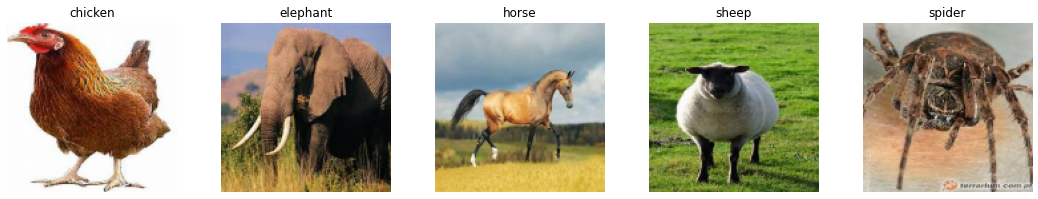

In [9]:
from skimage.io import imshow, imread_collection
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np


class_names = ['spider', 'horse', 'elephant', 'chicken', 'sheep']
path_to_image = 'raw-img/'
postfix = '/*.jpeg'
image_size = (128,128)

def create_data_set(data, class_name):
    for image in imread_collection(path_to_image + class_name + postfix):
        data['data'].append(resize(image, image_size))
        data['labels'].append(class_name)


data = dict()
data['data'] = []
data['labels'] = []

for class_name in class_names:
    create_data_set(data, class_name)


labels = np.unique(data['labels'])
 
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()

for ax, label in zip(axes, labels):
    index = data['labels'].index(label)
    ax.imshow(data['data'][index])
    ax.axis('off')
    ax.set_title(label)

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np


X = np.array(data['data'])
y = np.array(data['labels'])

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=33
)

In [11]:
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

scalify = StandardScaler()

hog_train = scalify.fit_transform(np.array([hog(img, orientations=9, pixels_per_cell=(9,9), cells_per_block=(4,4), channel_axis=-1) for img in X_train]))


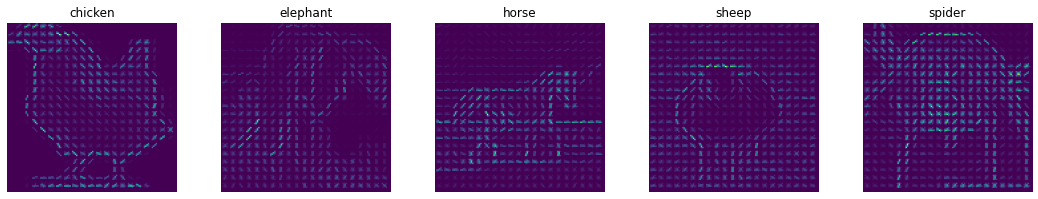

In [12]:
from skimage.transform import integral_image
from skimage import exposure,feature


fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 

for ax, label in zip(axes, labels):
    idx = data['labels'].index(label)
    fd, img = hog(data['data'][idx], orientations=15, pixels_per_cell=(6,6), cells_per_block=(6,6), visualize=True, channel_axis=-1) 
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

In [16]:
from sklearn import svm

mlp_classifier = svm.SVC()
mlp_classifier.fit(hog_train, y_train)

SVC(C=10)

In [17]:

hog_test = scalify.fit_transform(np.array([hog(img, orientations=9, pixels_per_cell=(9,9), cells_per_block=(4,4),channel_axis=-1) for img in X_test]))
labels_predicted = mlp_classifier.predict(hog_test)

print('Percentage correct: ', 100*np.sum(labels_predicted == y_test)/len(y_test))



Percentage correct:  84.16289592760181


              precision    recall  f1-score   support

     chicken       0.85      0.93      0.89        44
    elephant       0.91      0.78      0.84        40
       horse       0.86      0.84      0.85        57
       sheep       0.88      0.77      0.82        47
      spider       0.71      0.91      0.80        33

    accuracy                           0.84       221
   macro avg       0.84      0.84      0.84       221
weighted avg       0.85      0.84      0.84       221

[[41  0  1  0  2]
 [ 1 31  4  2  2]
 [ 1  3 48  2  3]
 [ 3  0  3 36  5]
 [ 2  0  0  1 30]]


'spider'

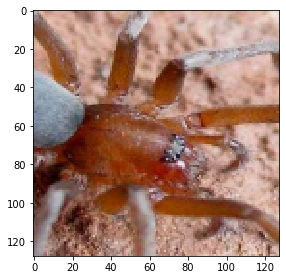

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, labels_predicted))
print(confusion_matrix(y_test, labels_predicted))

imshow(X_test[3])
labels_predicted[3]